<a href="https://colab.research.google.com/github/dagyeom23658/project_dayeom_chatbot/blob/main/%EA%B0%90%EC%84%B1%EB%B6%84%EC%84%9D_%EC%85%80%ED%94%84%EC%96%B4%ED%85%90%EC%85%98_%EC%9D%B4%EC%9A%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

# 트렌스포머



## 멀티헤드어텐션 구현

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = tf.keras.layers.Dense(embedding_dim)
        self.key_dense = tf.keras.layers.Dense(embedding_dim)
        self.value_dense = tf.keras.layers.Dense(embedding_dim)
        self.dense = tf.keras.layers.Dense(embedding_dim)

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

## 인코더 설계
- 멀티 헤드 어텐션에 두번째 서브층인 포지션 와이즈 피드 포워드 신경망을 추가하여 인코더 클래스를 설계

In [ ]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(dff, activation="relu"),
             tf.keras.layers.Dense(embedding_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs) # 첫번째 서브층 : 멀티 헤드 어텐션
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output) # Add & Norm
        ffn_output = self.ffn(out1) # 두번째 서브층 : 포지션 와이즈 피드 포워드 신경망
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output) # Add & Norm

## 포지션 임베딩
- 포지셔널 인코딩을 사용하였지만, 이번에는 위치 정보 자체를 학습을 하도록 하는 포지션 임베딩이라는 방법을 사용
- 포지션 임베딩은 임베딩 층(Embedding layer)를 사용하되, 위치 벡터를 학습하도록 하므로 임베딩 층의 첫번째 인자로 단어 집합의 크기가 아니라 문장의 최대 길이를 넣어줍니다.

In [ ]:
class TokenAndPositionEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.pos_emb = tf.keras.layers.Embedding(max_len, embedding_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
pip install konlpy

     |████████████████████████████████| 19.4 MB 7.6 MB/s 
     |████████████████████████████████| 448 kB 21.9 MB/s 
     |████████████████████████████████| 86 kB 5.1 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

import re
from konlpy.tag import Okt
from tqdm import tqdm  #상태진행률 표시
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/프로젝트1/감성대화말뭉치(최종데이터)_Training.xlsx')  # 코랩에 올리고 실행되기까지 시간이 좀 걸림.
train_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.


In [ ]:
val_data = pd.read_excel('/content/drive/MyDrive/프로젝트1/감성대화말뭉치(최종데이터)_Validation.xlsx')  # 코랩에 올리고 실행되기까지 시간이 좀 걸림.
val_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.,NaN,NaN


In [ ]:
stop_words1 = pd.read_excel('/content/drive/MyDrive/프로젝트1/ko_stop_words.xlsx',header=None) 

In [ ]:
stop_words2 = pd.read_excel('/content/drive/MyDrive/프로젝트1/ko_stop_words2.xlsx', header=None)  # 코랩에 올리고 실행되기까지 시간이 좀 걸림.
stop_words2.head()

,0,1,2
0,이,VCP,0.018280
1,있,VA,0.011699
2,하,VV,0.009774
3,것,NNB,0.009733
4,들,XSN,0.006898


In [ ]:
print(stop_words1.shape)
print(stop_words1.isna().sum())

stop1 = stop_words1.iloc[:,0].to_frame().values.tolist()
stop2 = stop_words1.iloc[:,1].to_frame().values.tolist()
stop3 = stop_words1.iloc[:,2].to_frame().dropna().values.tolist()

# 2차원리스트 -> 1차원리스트로 변환 https://codechacha.com/ko/python-flatten-list/

stop = stop1+stop2+stop3
print(len(stop))

stop2=sum(stop,[])
print(len(stop2))

stop_im = stop_words2[0].to_list()
stop_word=stop2 + stop_im
print(len(stop_word))

stop_words=set(stop_word)
print(stop_words)

(250, 3)
0     0
1     0
2    73
dtype: int64
677
677
777
{'불구하고', '그렇지 않으면', '이 정도의', '여덟', '해요', '메쓰겁다', '하지 않도록', '이럴정도로', '하', '첫번째로', '이천팔', '이천구', '에 있다', '어째서', '마저', '정도에 이르다', '얼마든지', '예를 들면', '다른', '남짓', '딱', '하고있었다', '당장', '더욱이는', '하는 편이 낫다', '없', '무슨', '상대적으로 말하자면', '시초에', '만약에', '겸사겸사', '향하다', '알', '근거하여', '아하', '와르르', '힘입어', '즉시', '그런즉', '개', '물론', '언젠가', '우선', '그러니까', '모르', '아이고', '하면 할수록', '까악', '그럼에도 불구하고', '네', '해도좋다', '우르르', '이번', '쾅쾅', '으로써', '무렵', '자신', '와', '어느 년도', '결과에 이르다', '이젠', '까지', '할지언정', '사람', '좍좍', '누구', '더라도', '불문하고', '바꾸어서 한다면', '여전히', '참나', '얼마 안 되는 것', '만 못하다', '할수있다', '을', '댕그', '하게될것이다', '고려하면', '하도록시키다', '놀라다', '그러한즉', '있', '시키다', '하도다', '그래도', '팍', '하나', '봐라', '그런데', '각자', '향해서', '가', '바꿔 말하면', '따위', '그때', '하물며', '나머지는', '소리', '로', '동안', '어떤것', '비슷하다', '의거하여', '할 생각이다', '하면된다', '넷', '제외하고', '개의치않고', '말', '저쪽', '않기 위해서', '엉엉', '만은 아니다', '에서', '안 그러면', '자마자', '바와같이', '지', '각각', '이와 같은', '허허', '구토하다', '이때', '지말고', '로부터', '이천칠', '인 듯하다', '겨우', '좋아', 

In [ ]:
stop_words.add(',')
stop_words.add('.')

# 데이터에 대한 이해

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [ ]:
train_data['번호']=train_data['번호'].astype('str')

# 앞뒤 공백 처리.
train_data =train_data.apply(lambda x: x.str.strip() , axis = 1)  #https://www.delftstack.com/ko/howto/python-pandas/difference-between-pandas-apply-map-and-applymap/
train_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.


In [ ]:
print('총 감정_대분류의 개수 : {}'.format(len(train_data['감정_대분류'].unique())))
print(train_data['감정_대분류'].unique())

총 감정_대분류의 개수 : 6
['기쁨' '불안' '당황' '슬픔' '분노' '상처']


In [ ]:
print('총 감정_소분류의 개수 : {}'.format(len(train_data['감정_소분류'].unique())))
print(train_data['감정_소분류'].unique())

총 감정_소분류의 개수 : 58
['신이 난' '스트레스 받는' '당황' '안도' '취약한' '우울한' '구역질 나는' '좌절한' '눈물이 나는' '배신당한'
 '남의 시선을 의식하는' '죄책감의' '당혹스러운' '분노' '두려운' '낙담한' '회의적인' '마비된' '혼란스러운' '흥분'
 '한심한' '염세적인' '안달하는' '걱정스러운' '조심스러운' '충격 받은' '상처' '불안' '노여워하는' '기쁨' '짜증내는'
 '환멸을 느끼는' '비통한' '혐오스러운' '억울한' '만족스러운' '부끄러운' '버려진' '고립된' '괴로워하는' '자신하는'
 '외로운' '방어적인' '편안한' '질투하는' '감사하는' '초조한' '실망한' '슬픔' '신뢰하는' '가난한, 불우한'
 '후회되는' '툴툴대는' '성가신' '열등감' '희생된' '느긋' '악의적인']


# 감성 레이블 만들기(숫자로 매핑)

In [ ]:
#감정 대분류와 소분류를 키값쌍으로 정렬.
dic = {}
for uni_class in train_data['감정_대분류'].unique():
    uni = train_data[train_data['감정_대분류'] == uni_class]['감정_소분류'].unique()
    dic[uni_class] = list(uni)
print(dic['기쁨'])

['신이 난', '안도', '흥분', '기쁨', '만족스러운', '자신하는', '편안한', '감사하는', '신뢰하는', '느긋']


In [ ]:
# 감정소분류주제 58개를 숫자레이블 딕셔너리로 변경
feel_class = train_data['감정_소분류'].unique()

i = 0
feel_dic = {}
for feel in feel_class:
    feel_dic[feel] = i
    i+=1
# feel_dic  #key:value = 감정소분류:숫자

In [ ]:
# 숫자로 감정을 찾을 수 있도록 reverse
feel_dic_reverse = {}
for key, value in feel_dic.items():
    feel_dic_reverse[value] = key
feel_dic_reverse

{0: '신이 난',
 1: '스트레스 받는',
 2: '당황',
 3: '안도',
 4: '취약한',
 5: '우울한',
 6: '구역질 나는',
 7: '좌절한',
 8: '눈물이 나는',
 9: '배신당한',
 10: '남의 시선을 의식하는',
 11: '죄책감의',
 12: '당혹스러운',
 13: '분노',
 14: '두려운',
 15: '낙담한',
 16: '회의적인',
 17: '마비된',
 18: '혼란스러운',
 19: '흥분',
 20: '한심한',
 21: '염세적인',
 22: '안달하는',
 23: '걱정스러운',
 24: '조심스러운',
 25: '충격 받은',
 26: '상처',
 27: '불안',
 28: '노여워하는',
 29: '기쁨',
 30: '짜증내는',
 31: '환멸을 느끼는',
 32: '비통한',
 33: '혐오스러운',
 34: '억울한',
 35: '만족스러운',
 36: '부끄러운',
 37: '버려진',
 38: '고립된',
 39: '괴로워하는',
 40: '자신하는',
 41: '외로운',
 42: '방어적인',
 43: '편안한',
 44: '질투하는',
 45: '감사하는',
 46: '초조한',
 47: '실망한',
 48: '슬픔',
 49: '신뢰하는',
 50: '가난한, 불우한',
 51: '후회되는',
 52: '툴툴대는',
 53: '성가신',
 54: '열등감',
 55: '희생된',
 56: '느긋',
 57: '악의적인'}

In [ ]:
feel_bic_class = train_data['감정_대분류'].unique()

i = 0
feel_bic_dic= {}
for feel in feel_bic_class:
    feel_bic_dic[feel] = i
    i+=1

In [ ]:
# 숫자로 감정을 찾을 수 있도록 reverse
feel_bic_dic_reverse = {}
for key, value in feel_bic_dic.items():
    feel_bic_dic_reverse[value] = key
feel_bic_dic_reverse

{0: '기쁨', 1: '불안', 2: '당황', 3: '슬픔', 4: '분노', 5: '상처'}

In [ ]:
feel_bic_df = train_data[['감정_대분류','사람문장1']]
feel_bic_df

,감정_대분류,사람문장1
0,기쁨,아내가 드디어 출산하게 되어서 정말 신이 나.
1,불안,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.
2,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.
3,기쁨,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.
4,기쁨,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.
...,...,...
40874,불안,같이 사는 친구가 애완견을 데려왔는데 대부분 내가 돌보고 있어. 내가 주인인가 혼란...
40875,기쁨,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.
40876,슬픔,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.
40877,기쁨,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.


In [ ]:
li = []
for feel in feel_bic_df['감정_대분류']:
    li.append(feel_bic_dic[feel])
feel_bic_df['대분류_num'] = li
feel_bic_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,감정_대분류,사람문장1,대분류_num
0,기쁨,아내가 드디어 출산하게 되어서 정말 신이 나.,0
1,불안,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,1
2,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,2
3,기쁨,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,0
4,기쁨,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,0
...,...,...,...
40874,불안,같이 사는 친구가 애완견을 데려왔는데 대부분 내가 돌보고 있어. 내가 주인인가 혼란...,1
40875,기쁨,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.,0
40876,슬픔,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.,3
40877,기쁨,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.,0


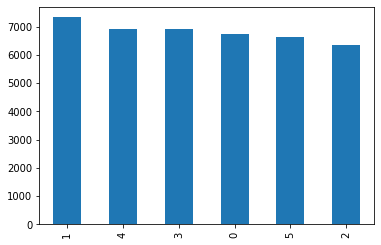

In [ ]:
# 레이블 값의 분포 시각화
plt.figure(figsize=(6, 4))
feel_bic_df['대분류_num'].value_counts().plot(kind='bar');

In [ ]:
print('가장많은 분포의 감정: ', feel_bic_dic_reverse[1])
print('감정분포 2위: ', feel_bic_dic_reverse[4])
print('감정분포 3위: ',feel_bic_dic_reverse[3])
print('감정분포 가장적은: ',feel_bic_dic_reverse[2])

가장많은 분포의 감정:  불안
감정분포 2위:  분노
감정분포 3위:  슬픔
감정분포 가장적은:  당황


In [ ]:
# 각 레이블이 몇개인가
print(feel_bic_df.groupby('대분류_num').size().reset_index(name='count')) 

   대분류_num  count
0        0   6731
1        1   7329
2        2   6360
3        3   6915
4        4   6920
5        5   6624


# train, val 전처리 완료 및 레이블 만들기

In [ ]:
# 공백제거
val_data['번호']=val_data['번호'].astype('str')
val_data =val_data.apply(lambda x: x.str.strip() , axis = 1)

In [ ]:
# 확인
val_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.,NaN,NaN


In [ ]:
# train셋과 val셋 비교
print('총 감정_대분류의 개수 : {}'.format(len(val_data['감정_대분류'].unique())))
set(val_data['감정_대분류'].unique()) == set(train_data['감정_대분류'].unique())

총 감정_대분류의 개수 : 6


True

In [ ]:
set(val_data['감정_소분류'].unique()) == set(train_data['감정_소분류'].unique())

True

In [ ]:
val_label = []
for feel in val_data['감정_대분류']:
    val_label.append(feel_bic_dic[feel])
pd.Series(val_label)

0       4
1       3
2       1
3       2
4       4
       ..
5125    0
5126    1
5127    4
5128    4
5129    4
Length: 5130, dtype: int64

In [ ]:
train_label = []
for feel in train_data['감정_대분류']:
    train_label.append(feel_bic_dic[feel])
np.array(train_label)

array([0, 1, 2, ..., 3, 0, 1])

# 토큰화

In [ ]:
from konlpy.tag import Okt
from konlpy.tag import Kkma
import re

In [ ]:
okt=Okt()
X_train = []
for sentence in train_data['사람문장1']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_words] # 불용어 제거
    X_train.append(stopwords_removed_sentence)
print(X_train[:3])

[['아내', '드디어', '출산', '하다', '되어다', '정말', '신'], ['당뇨', '랑', '합병증', '먹다', '하다', '약', '열', '넘어가다', '스트레스'], ['고등학교', '올라오다', '중학교', '보다', '수업', '갑자기', '어려워지다', '당황', '스럽다']]


In [ ]:
X_test = []
for sentence in val_data['사람문장1']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_words] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

### 정수인코딩

- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 우선, 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
word_index = tokenizer.word_index
print(tokenizer.word_index)   # 여기서 oov는 어떻게 되는거지?

# 0은 패딩을 위해 비워둠

{'하다': 1, '너무': 2, '친구': 3, '는': 4, '도': 5, '없다': 6, '보다': 7, '않다': 8, '은': 9, '좋다': 10, '못': 11, '받다': 12, '이야': 13, '되다': 14, '만': 15, '들다': 16, '돼다': 17, '회사': 18, '오늘': 19, '요즘': 20, '돈': 21, '정말': 22, '게': 23, '나르다': 24, '아내': 25, '싶다': 26, '걱정': 27, '스럽다': 28, '한테': 29, '가다': 30, '남편': 31, '하고': 32, '힘들다': 33, '?': 34, '모르다': 35, '결혼': 36, '나다': 37, '고': 38, '슬프다': 39, '자다': 40, '화가': 41, '다': 42, '많이': 43, '직장': 44, '오다': 45, '기분': 46, '아프다': 47, '!': 48, '마음': 49, '거': 50, '아들': 51, '나오다': 52, '되어다': 53, '당황': 54, '엄마': 55, '준비': 56, '많다': 57, '불안하다': 58, '당하다': 59, '건강': 60, '나이': 61, '해': 62, '랑': 63, '먹다': 64, '병원': 65, '어떻다': 66, '자식': 67, '가족': 68, '이제': 69, '학교': 70, '취업': 71, '부모님': 72, '기쁘다': 73, '인데': 74, '일이': 75, '자꾸': 76, '난': 77, '날': 78, '주다': 79, '속상하다': 80, '딸': 81, '걸': 82, '노후': 83, '짜증': 84, '은퇴': 85, '다니다': 86, '그렇다': 87, '아무': 88, '내다': 89, '어제': 90, '아니다': 91, '공부': 92, '라고': 93, '갑자기': 94, '몸': 95, '인': 96, '아빠': 97, '만나다': 98, '알다': 99, '스트레스': 100, '싫다'

In [ ]:
vocab_size = len(tokenizer.word_index) +1     # 단어집합의 크기

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

# 각 샘플 내의 단어들은 각 단어에 대한 정수로 변환된 것을 확인할 수 있습니다.

[[25, 193, 277, 1, 53, 22, 588], [340, 63, 1003, 64, 1, 248, 584, 1183, 100], [532, 1386, 1319, 7, 564, 94, 984, 54, 28]]


In [ ]:
# 훈련 데이터와 테스트 데이터의 문장과 레이블을 각각 저장합니다.
y_train = np.array(train_label)
y_test = np.array(val_label)

### 패딩

문장의 최대 길이 : 42
문장의 평균 길이 : 8.9839771031581


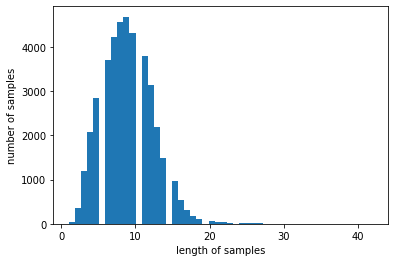

In [ ]:
print('문장의 최대 길이 :',max(len(text) for text in X_train))
print('문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(text) for text in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 전체 데이터의 길이 분포는 대체적으로 약 9내외의 길이를 가지는 것을 볼 수 있습니다. 

In [ ]:
# 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [ ]:
# 위의 분포 그래프를 봤을 때, max_len = 20이 적당할 것 같습니다. 이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인해봅시다. 채팅 특성상 엄청 긴 문장이 포함되지 않으므로, 최대길이로 모든 데이터를 패딩하면 됨. --> 그러나 별 차이 없었다고 한다.
max_len =  18          # 18 에서 99%
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 18 이하인 샘플의 비율: 99.24166442427652


In [ ]:
# 전체 훈련 데이터 중 약 99%의 리뷰가 18이하의 길이를 가지는 것을 확인했습니다. 모든 샘플의 길이를 18으로 맞추겠습니다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
# 훈련용, 테스트용 뉴스 기사 데이터의 레이블에 원-핫 인코딩을 합니다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
y_train

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
print('전체 데이터의 크기(shape):', X_train.shape)
print('레이블 데이터의 크기(shape):', y_train.shape)

전체 데이터의 크기(shape): (40879, 18)
레이블 데이터의 크기(shape): (40879, 6)


In [ ]:
print(X_train[0])
print(y_train[0])

[  0   0   0   0   0   0   0   0   0   0   0  25 193 277   1  53  22 588]
[1. 0. 0. 0. 0. 0.]


In [ ]:
embedding_dim = 32  # 각 단어의 임베딩 벡터의 차원
num_heads = 2  # 어텐션 헤드의 수
dff = 32  # 포지션 와이즈 피드 포워드 신경망의 은닉층의 크기

inputs = tf.keras.layers.Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(20, activation="relu")(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(6, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
# 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)합니다. 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_split=0.2)  #배치사이즈를 조절하니까 좀 개선되긴 하는 것 같다. 


# loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/3
1022/1022 [==============================] - 15s 13ms/step - loss: 1.3495 - acc: 0.4819 - val_loss: 1.1093 - val_acc: 0.5961
Epoch 2/3
1022/1022 [==============================] - 13s 12ms/step - loss: 1.0281 - acc: 0.6389 - val_loss: 1.0876 - val_acc: 0.6060
Epoch 3/3
161/161 [==============================] - 1s 6ms/step - loss: 1.1422 - acc: 0.5936

 테스트 정확도: 0.5936


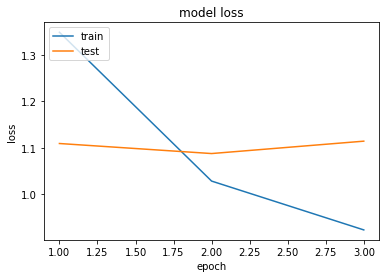

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
pip install git+https://github.com/ssut/py-hanspell.git

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-sjse4pdl
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-sjse4pdl
  Created wheel for py-hanspell: filename=py_hanspell-1.1-py3-none-any.whl size=4868 sha256=19a8a903ce4e0dff712926b1898766d72d86cca63427b1bb5ddc8518e3ad92c5
  Stored in directory: /tmp/pip-ephem-wheel-cache-ko2thsbh/wheels/ab/f5/7b/d4124bb329c905301baed80e2ae45aa14e824f62ebc3ec2cc4
Successfully built py-hanspell


In [ ]:
# 예측해보기
from hanspell import spell_checker
def sentiment_predict(new_sentence):
  spelled_sent = spell_checker.check(new_sentence)    # 챗봇에 단어를 입력할 때는 비문법이 많으므로 문법을 맞춰주고 띄어쓰기를 시켜준다. 이걸 추가하니까 성능이 훨씬 좋아졌다.
  hanspell_sent = spelled_sent.checked
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', hanspell_sent)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_words] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = model.predict(pad_new) # 예측
#   print(score[0, score.argmax()])
  return feel_bic_dic_reverse[score.argmax()]

In [ ]:
sentiment_predict('상장을 받았어')

'기쁨'

In [ ]:
sentiment_predict('오늘 학교에서 상을 받았어')  # 상을 구별못함. 이러면 곤란...

'슬픔'

In [ ]:
sentiment_predict('ㅋㅋㅋㅋㅋㅋ 오늘 학교에서 상받아떵') 

'슬픔'

In [ ]:
sentiment_predict('ㅋㅋㅋㅋㅋㅋ 오늘 학교에서 상받아서 너무 기분좋아')  # 직접적으로 기분을 말해주면 구분을 하는데, 상황에 따른 판별력은 떨어진다. 

'기쁨'

In [ ]:
sentiment_predict('아빠한테 맞았어')   # 누가봐도 상처인 건 구별한다. 

'상처'

In [ ]:
sentiment_predict('남자친구가 샤넬백 사줌')  

'기쁨'

In [ ]:
sentiment_predict('남자친구한테 샤넬백 사줌') 

'기쁨'

In [ ]:
sentiment_predict('아프리카 난민에게 기부함')

'상처'

In [ ]:
sentiment_predict('카리나는 너무 예쁘다')  # 나름 일리있는 것 같기도...ㅋㅋㅋ

'상처'

In [ ]:
sentiment_predict('난 너무 못생겼어') 

'분노'

In [ ]:
# 임베딩이나, 불용어 처리 같은 것이 .. 큰 차이가 없는 것 같다. 그것보다는 하이퍼파라미터를 조절하는게 정확도 개선에 나을 것 같기도 하고...
# 사실 잘 모르겠다. 
# 우리나라 말은 특히, 한 단어안에 여러가지 중의적 의미를 내포하고 있는 경우가 많아서 정확도가 더 떨어지는 것 같기도 하다. 

# 한국어 챗봇에서 가장 중요한 건, 맞춤법 검사기를 꼭 넣어야 한다는 것이다. 